<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/Exercise_3_GNN_for_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Two moons with an invertible Neural Network

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F

In [73]:
### modified coupling layer class
import torch
import torch.nn as nn
import torch.nn.functional as F

class CouplingLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CouplingLayer, self).__init__()
        # Neural networks for the first half of the dimensions
        self.fc1 = nn.Linear(input_size // 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Translation coefficient
        self.fc3 = nn.Linear(hidden_size, input_size // 2)
        # Scaling coefficient
        self.fc4 = nn.Linear(hidden_size, input_size // 2)

    def forward(self, x):
        #print("___ inside the coupling layer's forward function____")
        #print("x is:"); print(x)
        #print("shape of x is:",x.shape)
        # Split the input into two halves
        x_a, x_b = x.chunk(2, dim=1)
        #print("shape x_a is:",x_a.shape)
        #print("shape x_b is:",x_b.shape)

        # Apply neural network to calculate coefficients
        h = F.relu(self.fc1(x_a))
        h = F.relu(self.fc2(h))
        translation = self.fc3(h)
        scaling_before_exp = torch.tanh(self.fc4(h))### taking the tanh
        #print("_"*20)
        #print("scaling if I dont take tanh:"); print(scaling_before_exp)
        scaling = torch.exp(scaling_before_exp)


        # Apply the affine transformation
        y_b = x_b * scaling + translation

        # Concatenate the transformed halves
        y = torch.cat([x_a, y_b], dim=1)
        #print(" shape of y is (tensor after the coupling layer):");print(y.shape)
        return y, scaling_before_exp

    def backward(self, y):
        # Split the input into two halves
        y_a, y_b = y.chunk(2, dim=1)

        # Apply neural network to calculate coefficients (reverse)
        h = F.relu(self.fc1(y_a))
        h = F.relu(self.fc2(h))
        translation = self.fc3(h)
        scaling_before_exp = self.fc4(h)
        scaling = torch.exp(torch.tanh(scaling_before_exp))

        # Reverse the operations to reconstruct the original input
        x_a = y_a
        x_b = (y_b - translation) / scaling

        # Concatenate the reconstructed halves
        x = torch.cat([x_a, x_b], dim=1)
        return x

In [217]:
class RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks):
        super(RealNVP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks

        # List of coupling layers
        self.coupling_layers = nn.ModuleList([
            CouplingLayer(input_size, hidden_size) for _ in range(blocks)
        ])
        #print("self.input size is:",self.input_size)


        # List to store orthonormal matrices
        self.orthonormal_matrices = [self._get_orthonormal_matrix(input_size) for _ in range(blocks)]
        # print("set of orthogonal matrixes are")
        # print(self.orthonormal_matrices)
        # print("some test check: "); print(type(self.orthonormal_matrices[0]))
        # print("shape is:");print(self.orthonormal_matrices)

        # List to store scaling_before_exp for each block
        self.scaling_before_exp_list = []

    def _get_orthonormal_matrix(self, size):
        # Function to generate a random orthonormal matrix
        w = torch.randn(size, size)
        q, _ = torch.linalg.qr(w,'reduced')
        return q

    def forward_realnvp(self, x):
        #print("inside the forward_realnvp function")
        scaling_before_exp_list = []
        for i in range(self.blocks):
            #print("type of (self.orthonormal_matrices[0]):",type(self.orthonormal_matrices[0]))
            #print("x is:");print(x)
            #print("self.orthonormal_matrices[i]:");print(self.orthonormal_matrices[i])

            # Apply random orthonormal matrix
            x = torch.matmul(x, self.orthonormal_matrices[i])

            # Apply coupling layer
            x, scaling_before_exp = self.coupling_layers[i].forward(x)
            scaling_before_exp_list.append(scaling_before_exp)

        self.scaling_before_exp_list = scaling_before_exp_list
        return x

    def encode(self, x):
        # Encoding is the forward pass through the RealNVP model
        return self.forward_realnvp(x)

    def decode(self, z):
        # Reverse transformations for decoding
        for i in reversed(range(self.blocks)):

            # Apply coupling layer (reverse)
            z = self.coupling_layers[i].backward(z)

            # Apply random orthonormal matrix (reverse)
            z = torch.matmul(z, self.orthonormal_matrices[i].t())
        return z

    def sample(self, num_samples=1000):
        # Generate random samples from a standard normal distribution
        with torch.no_grad():
            z = torch.randn(num_samples, self.input_size)

        # Apply the reverse transformations (decoder) to generate synthetic samples
        synthetic_samples = self.decode(z)
        return synthetic_samples

In [150]:
### defining our loss function
def calculate_loss(transformed_x, scaling_before_exp_list, dataset_length):
    """
    Calculate the loss for the RealNVP model.

    Args:
    - transformed_x (tensor): Transformed data produced by the RealNVP model.
    - scaling_before_exp_list (list): List of scaling_before_exp values for each block.
    - dataset_length (int): The length of the dataset.

    Returns:
    - loss (tensor): The calculated loss value.
    """
    #print("******************inside the calculate loss function**************")
    # print("transformed x's shape is:", transformed_x.shape)
    # print("scaling_before_exp_list is:", scaling_before_exp_list)

    # Calculate the first term of the loss (negative log-likelihood term)
    first_term = 0.5*torch.sum(transformed_x**2)

    # Calculate the second term of the loss (sum over scaling_before_exp values)
    # second_term = 0.0
    # for scaling_before_exp in scaling_before_exp_list:
    #     second_term -= scaling_before_exp.sum()

    second_term= -torch.sum(torch.cat(scaling_before_exp_list))#torch.sum(torch.stack(model.scaling_before_exp_list), dim=0)

    # Calculate the total loss
    loss = (first_term + second_term) / dataset_length
    #print(f"first term is: {first_term.item()} and the second term is {second_term.item()}")

    return loss


In [109]:
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

def train_and_evaluate(model, train_loader, val_loader, num_epochs=10, lr=0.001, print_after=1):
    """
    Train the RealNVP model and evaluate on a validation dataset.

    Args:
    - model (RealNVP): The RealNVP model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - lr (float): Learning rate for the optimizer.
    - print_after (int): Number of epochs after which to print the training and validation loss.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    """

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses

    for epoch in range(num_epochs):
        total_train_loss = 0.0

        # Training phase
        model.train()  # Set the model to training mode
        for data in train_loader:
            inputs= data

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass (encoding)
            encoded = model.encode(inputs)

            # Loss calculation
            train_loss = calculate_loss(encoded, model.scaling_before_exp_list, len(train_loader))

            # Backward pass (gradient computation)
            train_loss.backward()

            ### added recently: clip the gradients
            clip_grad_norm_(model.parameters(), max_norm=1.0)  # Adjust max_norm as needed

            # Update weights
            optimizer.step()

            total_train_loss += train_loss.item()

        # Average training loss for the epoch
        average_train_loss = total_train_loss / len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()  # Set the model to evaluation mode
            total_val_loss = 0.0
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data

                    # Forward pass (encoding) for validation
                    val_encoded = model.encode(val_inputs)

                    # Loss calculation for validation
                    val_loss = calculate_loss(val_encoded, model.scaling_before_exp_list, len(val_loader))

                    total_val_loss += val_loss.item()

            # Average validation loss for the epoch
            average_val_loss = total_val_loss / len(val_loader)

            # Print training and validation losses together
            if (epoch + 1) % print_after == 0:
                print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_train_loss}, Validation Loss: {average_val_loss}")

            # Append losses to the lists
            train_losses.append(average_train_loss)
            val_losses.append(average_val_loss)

        # Set the model back to training mode
        model.train()

    print("Training complete")

    return train_losses, val_losses

### Some helper functions for plotting

In [122]:
# function to plot training and validation losses
def plot_losses(epoch_train_losses, epoch_val_losses, want_log_scale=True):
    """
    Plot training and validation losses over epochs on a log scale.

    Args:
        epoch_train_losses (list): List of training losses for each epoch.
        epoch_val_losses (list): List of validation losses for each epoch.
    """
    epochs = range(1, len(epoch_train_losses) + 1)

    plt.plot(epochs, epoch_train_losses, label='Training Loss')
    plt.plot(epochs, epoch_val_losses, label='Validation Loss')

    if want_log_scale:
      plt.yscale('log')  # Set the y-axis to a logarithmic scale
      plt.title('Training and Validation reconstruction Losses (Log Scale)',fontsize=10)
    else:
      plt.title('Training and Validation reconstruction Losses',fontsize=10)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [78]:
def visualize_synthetic_data(original_data, synthetic_data):
    """
    Scatter plot to visualize the original and synthetic data in 2D.

    Args:
    - original_data (torch.Tensor): Original data (2D).
    - synthetic_data (torch.Tensor): Synthetic data (2D).

    Returns:
    - None: Displays the scatter plot.
    """
    # Ensure both original and synthetic data are converted to numpy arrays
    with torch.no_grad():
        # Convert PyTorch tensors to numpy arrays
        original_np = original_data.numpy()
        synthetic_np = synthetic_data.numpy()

        # Scatter plot of original and synthetic data
        plt.scatter(original_np[:, 0], original_np[:, 1], label='Original', alpha=0.5)
        plt.scatter(synthetic_np[:, 0], synthetic_np[:, 1], label='Synthetic', alpha=0.5)

        # Add labels and title
        plt.xlabel("dimension-1")
        plt.ylabel("dimension-2")
        plt.title('Original vs Synthetic Data')

        # Add legend
        plt.legend()

        # Display the plot
        plt.show()


In [195]:
def plot_code_distribution(model, test_loader, num_samples=1000):
    """
    Plot the code distribution obtained by applying the trained RealNVP model to a test dataset.

    Args:
    - model (RealNVP): Trained RealNVP model.
    - test_loader (DataLoader): DataLoader for the test dataset.
    - num_samples (int): Number of samples to visualize.

    Returns:
    None (displays the plot).
    """
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        # Concatenate multiple batches to obtain more samples
        test_samples = torch.cat([batch for batch in test_loader], dim=0)

        # Assuming your model has an `encode` method
        code_samples = model.encode(test_samples[:num_samples])

        # Convert PyTorch tensor to numpy array
        code_np = code_samples.numpy()

        # Scatter plot of code distribution
        plt.scatter(code_np[:, 0], code_np[:, 1], label='Code Distribution', alpha=0.5)
        plt.xlabel("Code Dimension 1")
        plt.ylabel("Code Dimension 2")
        plt.title('Code Distribution')
        plt.legend()
        plt.show()

### loading the two moons dataset

In [79]:
dataset_sizes = [ 500, 1000, 5000]

# Generate datasets of varying sizes
train_datasets = {}
val_datasets = {}
datasets = {}

for size in dataset_sizes:
    X, y = make_moons(n_samples=size, noise=0.1)
    datasets[size] = {'X': X, 'y': y}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_datasets[size] = {'X': torch.FloatTensor(X_train), 'y': y_train}
    val_datasets[size] = {'X': torch.FloatTensor(X_test), 'y': y_test}

# # Visualize the training datasets
# plt.figure(figsize=(12, 8))

# for i, size in enumerate(dataset_sizes, 1):
#     plt.subplot(2, 2, i)
#     plt.scatter(datasets[size]['X'][:, 0], datasets[size]['X'][:, 1], c=datasets[size]['y'])
#     plt.title(f'Dataset Size: {size}')

# plt.show()


shape of the data_considered
torch.Size([3500, 2])
Epoch 1/10, Training Loss: -0.012698033607441837, Validation Loss: -0.17389673415690343
Epoch 2/10, Training Loss: -0.09564000276679342, Validation Loss: -0.263984782066434
Epoch 3/10, Training Loss: -0.12156500579281286, Validation Loss: -0.27716694518606716
Epoch 4/10, Training Loss: -0.13485479908572, Validation Loss: -0.3201864605888407
Epoch 5/10, Training Loss: -0.14383480999280107, Validation Loss: -0.3453981920759729
Epoch 6/10, Training Loss: -0.1492482510649345, Validation Loss: -0.3545578879878876
Epoch 7/10, Training Loss: -0.1551939609375867, Validation Loss: -0.35226434532632217
Epoch 8/10, Training Loss: -0.15968476059761913, Validation Loss: -0.36379795188599445
Epoch 9/10, Training Loss: -0.16040095324543388, Validation Loss: -0.36042719223397846
Epoch 10/10, Training Loss: -0.1632220556112853, Validation Loss: -0.3778557931172087
Training complete


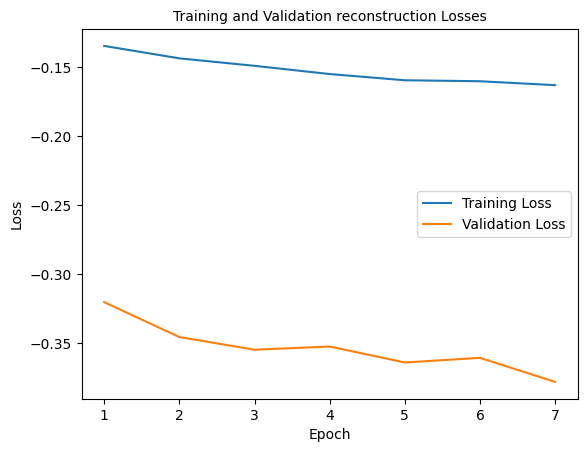

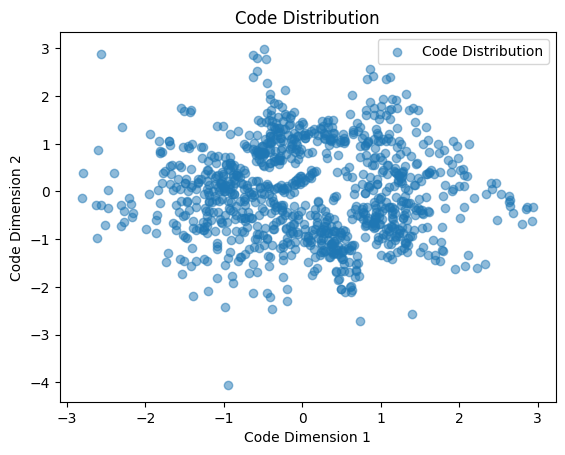

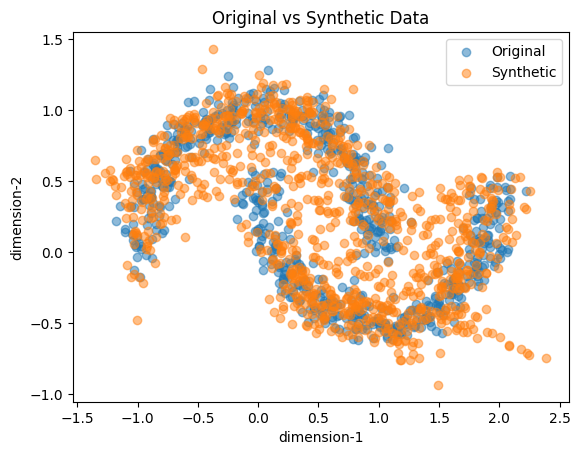

In [222]:
### creating the dataloader for the make moons dataset
from torch.utils.data import DataLoader, TensorDataset

### Trial run
import numpy as np
input_size=2
hidden_size=200### do I really need this to be this large?
blocks=4 ####### larger number of blocks ensures that the code distribution is indeed gaussian
print_after=1

#### data for the two-moons model
dataset_size=5000
batch_size=32
data_considered=train_datasets[dataset_size]['X']
print("shape of the data_considered"); print(data_considered.shape)
train_loader = torch.utils.data.DataLoader(data_considered, batch_size=batch_size, shuffle=True)
val_loader= torch.utils.data.DataLoader(val_datasets[dataset_size]['X'], batch_size=batch_size, shuffle=True)
####

### instantiate the model
model= RealNVP(input_size=2, hidden_size= hidden_size, blocks=blocks)

## train the model
train_losses, val_losses= train_and_evaluate(model, train_loader, val_loader, num_epochs=10, lr=0.0001, print_after=1)
#train_inn(model, train_loader, num_epochs=500, lr=0.01, print_after=10)
#1. 0.00005 num_epochs=20,dataset_size=5000, batchsize=64: right now I have kept blocks=10: code distribution was more gaussian and generated data was comparitively better

# plotting the loss
plot_losses(train_losses[3:], val_losses[3:], want_log_scale=0)
plt.show()

# Example usage:
plot_code_distribution(model=model, test_loader=val_loader, num_samples=1000)
plt.show()

### plot the synthetic data and the original data
synthetic_data=model.sample(num_samples=1000)
visualize_synthetic_data(train_datasets[1000]['X'], synthetic_data)
plt.show()

### Observation:

1. Number of coupling blocks:

  1. We observed that the higher number of coupling blocks ensures that the code distribution is gaussian. We also observed improvement in the quality of synthetic data.

# Tasks for the prob 1 of exercise 2 we need to do:

Hyperparameters involved:

1. Size of the training set
2. Number of epochs
3. Learning rate


1. Check the effect of these 3 hyperparameters on the model quality.
  1. Check for the quality of the code distribution (it should be indeed standard normal)
  2. Check the quality of the generated data: RealNVP should have a function `RealNVP.sample(self,num_samples)` that generates the requested number of synthetic points. REPORT the MMD between a testset and generated datapoints: to be mre specific show that visually better results correspond to the smaller MMD.

### ~~Tasks to do atm~~:

1. ~~check if the model is implemented correctly.~~
2. MOST IMPORTANTLY: is the loss function implemented correctly? when I return the abs(loss) in the `calculate_loss` function, I see some training and improvement. IDK whether the loss function I have implemented is correct or not!

### Everything below is garbage

In [84]:
# seperate functions for training and validation.
# import torch.optim as optim
# def train_inn(model, train_loader, num_epochs=10, lr=0.001, print_after=10):
#     """
#     Train the RealNVP model.

#     Args:
#     - model (RealNVP): The RealNVP model to be trained.
#     - train_loader (DataLoader): DataLoader for the training dataset.
#     - num_epochs (int): Number of training epochs.
#     - lr (float): Learning rate for the optimizer.
#     - print_after (int): Number of epochs after which to print the training loss.

#     Returns:
#     - train_losses (list): List of training losses for each epoch.
#     """

#     # Define the optimizer
#     optimizer = optim.Adam(model.parameters(), lr=lr)

#     train_losses = []  # List to store training losses

#     for epoch in range(num_epochs):
#         total_train_loss = 0.0

#         # Training phase
#         model.train()  # Set the model to training mode
#         for data in train_loader:
#             inputs = data#[0] # there is something here which I really need to look into
#             #print("data from train_loader is inputs is:"); print(inputs)

#             # Zero the gradients
#             optimizer.zero_grad()

#             # Forward pass (encoding)
#             encoded = model.encode(inputs)

#             # Loss calculation
#             train_loss = calculate_loss(encoded, model.scaling_before_exp_list, len(train_loader))

#             # Backward pass (gradient computation)
#             train_loss.backward()

#             # Update weights
#             optimizer.step()

#             total_train_loss += train_loss.item()

#         # Average training loss for the epoch
#         average_train_loss = total_train_loss / len(train_loader)

#         # Print training loss after specified number of epochs
#         if (epoch + 1) % print_after == 0:
#             print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_train_loss}")

#         # Append losses to the list
#         train_losses.append(average_train_loss)

#     print("Training complete")

#     return train_losses


# def validate_inn(model, val_loader,  print_after=10):
#     """
#     Validate the RealNVP model.

#     Args:
#     - model (RealNVP): The RealNVP model to be validated.
#     - val_loader (DataLoader): DataLoader for the validation dataset.
#     - print_after (int): Number of epochs after which to print the validation loss.

#     Returns:
#     - val_losses (list): List of validation losses for each epoch.
#     """

#     val_losses = []  # List to store validation losses

#     model.eval()  # Set the model to evaluation mode
#     total_val_loss = 0.0

#     with torch.no_grad():
#         for epoch, val_data in enumerate(val_loader, 1):
#             val_inputs = val_data

#             # Forward pass (encoding) for validation
#             val_encoded = model.encode(val_inputs)

#             # Loss calculation for validation
#             val_loss = calculate_loss(val_encoded, model.scaling_before_exp_list, len(val_loader))

#             total_val_loss += val_loss.item()

#             # Print validation loss after specified number of epochs
#             if epoch % print_after == 0:
#                 average_val_loss = total_val_loss / epoch
#                 print(f"Epoch {epoch}/{len(val_loader)}, Validation Loss: {average_val_loss}")

#                 # Append average validation loss to the list
#                 val_losses.append(average_val_loss)

#     print("Validation complete")

#     return val_losses

In [85]:
# import torch


# # Example data
# data_size = 500
# input_size = 2
# hidden_size = 256
# blocks = 3
# print_after = 10

# # Create a dummy dataset
# X = torch.randn(data_size, input_size)
# print("shape of the dataset is:"); print(X.shape)
# print("X is :"); print(X)

# # Create a DataLoader for the dataset
# train_dataset = TensorDataset(X)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # Initialize the RealNVP model
# model2 = RealNVP(input_size, hidden_size, blocks)

# # Train the model
# train_losses = train_inn(model2, train_loader, num_epochs=1, lr=0.001, print_after=1)

# ## Print the final training and validation losses
# #print(f"Final Training Loss: {train_losses[-1]}, Final Validation Loss: {val_losses[-1]}")
